### Perform sentimental analysis:
+ 1) Extract reviews of any product from ecommerce website like amazon
+ 2) Perform emotion mining

In [1]:
#Import Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from plotly import graph_objs as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



# for showing all the plots inline
%matplotlib inline

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load the dataset
reviews=pd.read_csv('Amazon_Reviews_Oneplus_Nord_CE2.csv')
reviews.drop(['Unnamed: 0'],inplace=True,axis=1)
reviews

,Rating,Title,Review,Review_Date
0,1.0,Worst phone ever,Hang problem,25 February 2022
1,2.0,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,26 February 2022
2,5.0,Awesome look,Camera is so good n very fast phone back look ...,25 February 2022
3,3.0,One plus losing is originality!!!,The media could not be loaded.\n ...,28 February 2022
4,1.0,Read,I got my delivery on 23 feb when I unboxed the...,26 February 2022
...,...,...,...,...
4123,1.0,Heating up,Heating up even for moderate use. Heat increas...,21 June 2022
4124,5.0,Over all best,Very Nice,22 June 2022
4125,1.0,Voice cut,All features are good but call cut frequently ...,16 June 2022
4126,4.0,Battery backup is low,As it has fast charging but also drains the ba...,18 June 2022


### Data Exploration.

In [4]:
reviews.Rating.describe()


count    4128.000000
mean        3.780766
std         1.487904
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: Rating, dtype: float64

### Number of Words

In [5]:
reviews['word_count'] = reviews['Review'].apply(lambda x: len(str(x).split(" ")))
reviews[['Review','word_count']].head()

,Review,word_count
0,Hang problem,2
1,I'm writing this review after using 3days !!!B...,65
2,Camera is so good n very fast phone back look ...,170
3,The media could not be loaded.\n ...,197
4,I got my delivery on 23 feb when I unboxed the...,110


### Number of Characters

In [13]:
reviews['char_count'] = reviews['Review'].str.len() ## this also includes spaces
reviews[['Review','char_count']].head()

,Review,char_count
0,Hang problem,12.0
1,I'm writing this review after using 3days !!!B...,383.0
2,Camera is so good n very fast phone back look ...,882.0
3,The media could not be loaded.\n ...,963.0
4,I got my delivery on 23 feb when I unboxed the...,622.0


### Average Word Length

In [6]:
def avg_word(sentence):
  words = str(sentence).split()
  return (sum(len(word) for word in words)/len(words))

reviews['avg_word'] = reviews['Review'].apply(lambda x: avg_word(x))
reviews[['Review','avg_word']].head()

,Review,avg_word
0,Hang problem,5.500000
1,I'm writing this review after using 3days !!!B...,4.907692
2,Camera is so good n very fast phone back look ...,4.194118
3,The media could not be loaded.\n ...,4.181319
4,I got my delivery on 23 feb when I unboxed the...,4.663636


### Number of stopwords

In [7]:
reviews['stopwords'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x in stopwords]))
reviews[['Review','stopwords']].head()

,Review,stopwords
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,15
2,Camera is so good n very fast phone back look ...,51
3,The media could not be loaded.\n ...,59
4,I got my delivery on 23 feb when I unboxed the...,48


### Number of special characters

In [9]:
reviews['hashtags'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
reviews[['Review','hashtags']].head()

,Review,hashtags
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,0
2,Camera is so good n very fast phone back look ...,0
3,The media could not be loaded.\n ...,0
4,I got my delivery on 23 feb when I unboxed the...,0


### Number of numerics

In [10]:
reviews['numerics'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
reviews[['Review','numerics']].head()

,Review,numerics
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,0
2,Camera is so good n very fast phone back look ...,1
3,The media could not be loaded.\n ...,6
4,I got my delivery on 23 feb when I unboxed the...,1


### Number of Uppercase words

In [11]:
reviews['upper'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
reviews[['Review','upper']].head()

,Review,upper
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,0
2,Camera is so good n very fast phone back look ...,2
3,The media could not be loaded.\n ...,13
4,I got my delivery on 23 feb when I unboxed the...,3


In [14]:
reviews.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','upper'],axis=1,inplace=True)

### Feature Engineering

In [18]:
print(reviews['Review_Date'].str.split(' ').str[0],'\n',
      reviews['Review_Date'].str.split(' ').str[1],'\n',
      reviews['Review_Date'].str.split(' ').str[2])

0       25
1       26
2       25
3       28
4       26
        ..
4123    21
4124    22
4125    16
4126    18
4127    20
Name: Review_Date, Length: 4128, dtype: object 
 0       February
1       February
2       February
3       February
4       February
          ...   
4123        June
4124        June
4125        June
4126        June
4127        June
Name: Review_Date, Length: 4128, dtype: object 
 0       2022
1       2022
2       2022
3       2022
4       2022
        ... 
4123    2022
4124    2022
4125    2022
4126    2022
4127    2022
Name: Review_Date, Length: 4128, dtype: object


### Spliting Review Date into Three seperate Columns (Year,Month,Day)


In [19]:
df=reviews.copy()
df['Date']=df['Review_Date'].str.split(' ').str[0]
df['Month']=df['Review_Date'].str.split(' ').str[1]
df['Year']=df['Review_Date'].str.split(' ').str[2]
df[['Date','Month','Year']]

,Date,Month,Year
0,25,February,2022
1,26,February,2022
2,25,February,2022
3,28,February,2022
4,26,February,2022
...,...,...,...
4123,21,June,2022
4124,22,June,2022
4125,16,June,2022
4126,18,June,2022


In [20]:
df.Month.value_counts()


March       1321
April       1183
May          803
June         540
February     281
Name: Month, dtype: int64

### Change 'month' from words to numbers for easier analysis

In [21]:
order={'Month':{'February':2,'March':3,'April':4,'May':5,'June':6}}
df1= df.copy()
df1=df1.replace(order)
df1[['Month']]

,Month
0,2
1,2
2,2
3,2
4,2
...,...
4123,6
4124,6
4125,6
4126,6


In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4128 entries, 0 to 4127
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rating       4128 non-null   float64
 1   Title        4128 non-null   object 
 2   Review       3893 non-null   object 
 3   Review_Date  4128 non-null   object 
 4   Date         4128 non-null   object 
 5   Month        4128 non-null   int64  
 6   Year         4128 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 225.9+ KB


In [23]:
df1[['Date','Year']]=df1[['Date','Year']].astype('int64')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4128 entries, 0 to 4127
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rating       4128 non-null   float64
 1   Title        4128 non-null   object 
 2   Review       3893 non-null   object 
 3   Review_Date  4128 non-null   object 
 4   Date         4128 non-null   int64  
 5   Month        4128 non-null   int64  
 6   Year         4128 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 225.9+ KB


### Dropping the Original Columns after splitting the data

In [24]:
df1.drop('Review_Date',axis=1, inplace=True)
df1.head()

,Rating,Title,Review,Date,Month,Year
0,1.0,Worst phone ever,Hang problem,25,2,2022
1,2.0,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,26,2,2022
2,5.0,Awesome look,Camera is so good n very fast phone back look ...,25,2,2022
3,3.0,One plus losing is originality!!!,The media could not be loaded.\n ...,28,2,2022
4,1.0,Read,I got my delivery on 23 feb when I unboxed the...,26,2,2022


In [25]:
df

,Rating,Title,Review,Review_Date,Date,Month,Year
0,1.0,Worst phone ever,Hang problem,25 February 2022,25,February,2022
1,2.0,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,26 February 2022,26,February,2022
2,5.0,Awesome look,Camera is so good n very fast phone back look ...,25 February 2022,25,February,2022
3,3.0,One plus losing is originality!!!,The media could not be loaded.\n ...,28 February 2022,28,February,2022
4,1.0,Read,I got my delivery on 23 feb when I unboxed the...,26 February 2022,26,February,2022
...,...,...,...,...,...,...,...
4123,1.0,Heating up,Heating up even for moderate use. Heat increas...,21 June 2022,21,June,2022
4124,5.0,Over all best,Very Nice,22 June 2022,22,June,2022
4125,1.0,Voice cut,All features are good but call cut frequently ...,16 June 2022,16,June,2022
4126,4.0,Battery backup is low,As it has fast charging but also drains the ba...,18 June 2022,18,June,2022


## Data Visualization

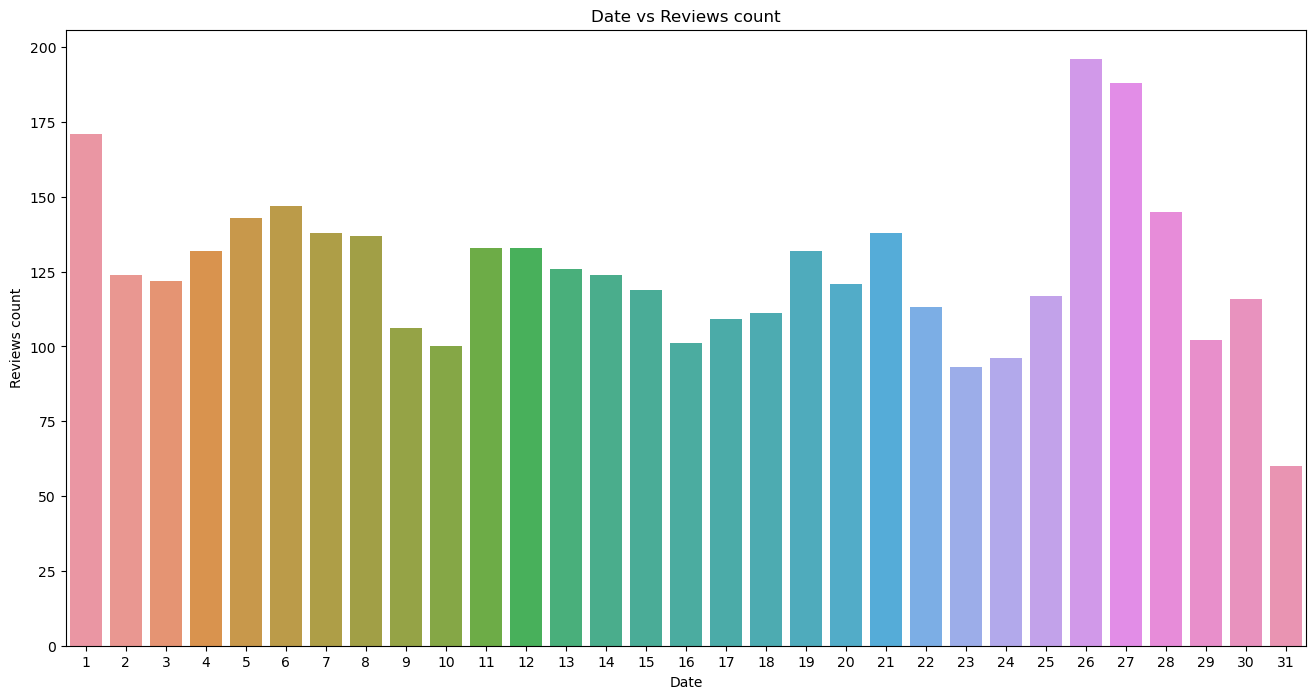

In [26]:
#Creating a dataframe
dayreview = pd.DataFrame(df.groupby('Date')['Review'].count()).reset_index()
dayreview['Date'] = dayreview['Date'].astype('int64')
dayreview.sort_values(by = ['Date'])

#Plotting the graph
plt.figure(figsize=(16,8))
sns.barplot(x = "Date", y = "Review", data = dayreview)
plt.title('Date vs Reviews count')
plt.xlabel('Date')
plt.ylabel('Reviews count')
plt.show()

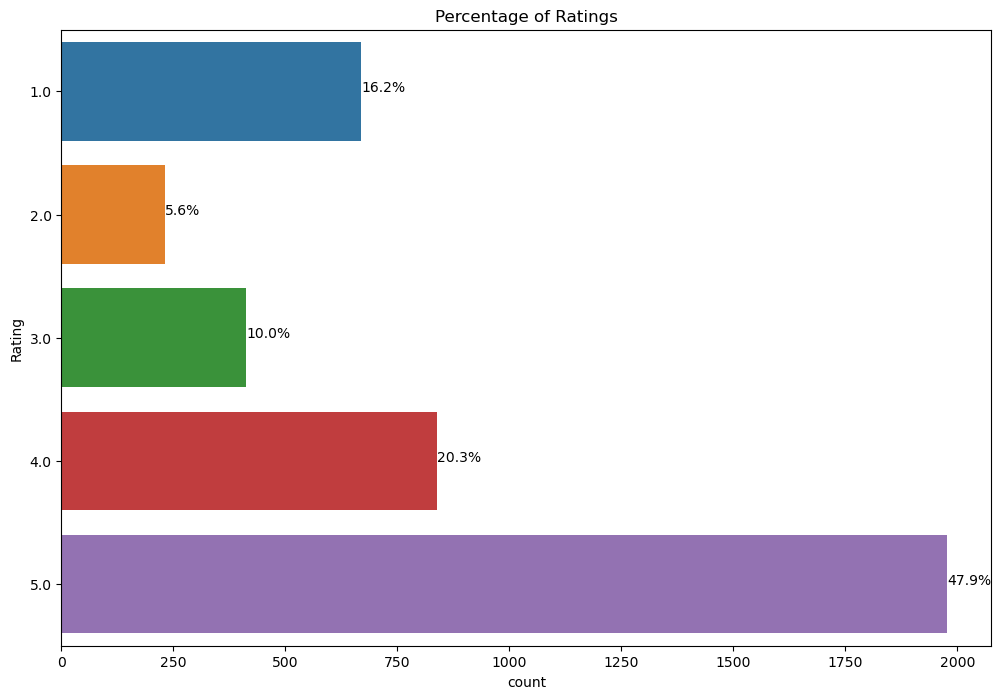

In [27]:
plt.figure(figsize=(12,8))
plt.title('Percentage of Ratings')
ax = sns.countplot(y = 'Rating', data = reviews)
total = len(reviews)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

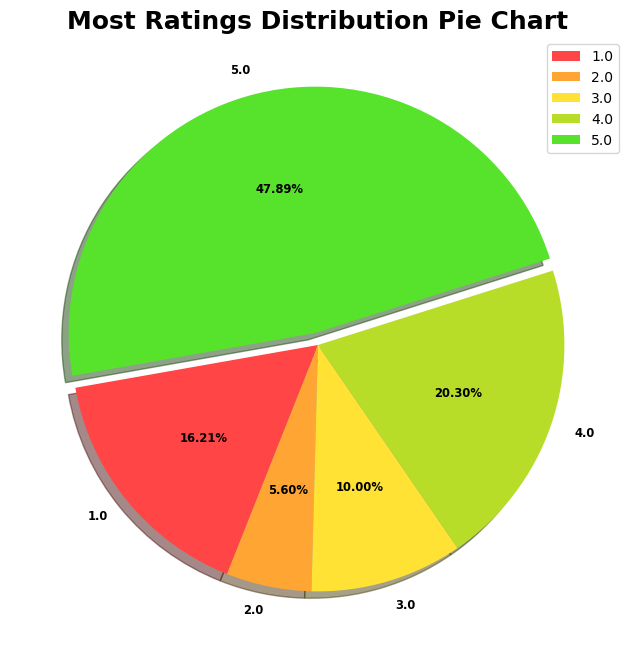

In [29]:
plt.figure(figsize = (12,8))
plt.pie(df['Rating'].value_counts().sort_index(),
       labels=df['Rating'].value_counts().sort_index().index,
       explode = [0.00,0.0,0.0,0.0,0.05],
       autopct= '%.2f%%',
        colors = ["#ff4545", "#ffa534",'#ffe234','#b7dd29','#57e32c'],
       shadow= True,
       startangle= 190,
       textprops = {'size':'small',
                   'fontweight':'bold',
                    
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Most Ratings Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

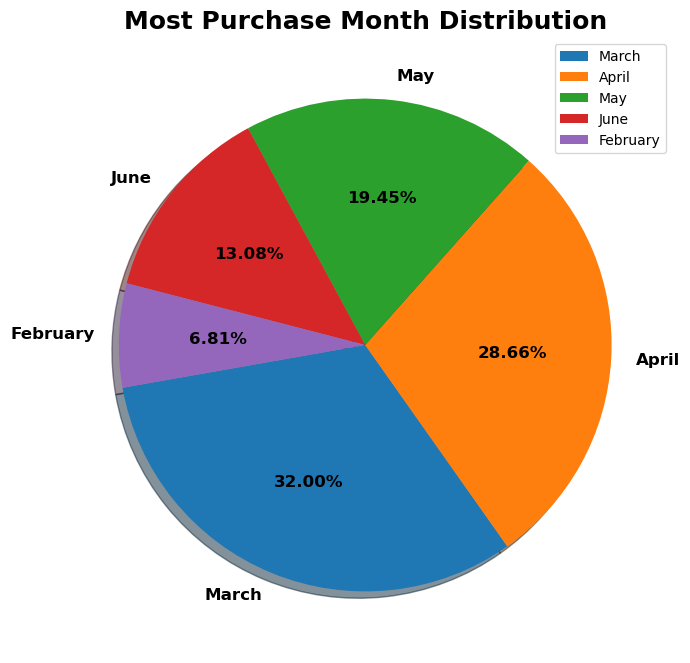

In [31]:
plt.figure(figsize = (12,8))
plt.pie(df['Month'].value_counts(),
       labels=df['Month'].value_counts().index,
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Most Purchase Month Distribution", fontsize = 18, fontweight = 'bold')
plt.show()

### BasicText Preprocessing

#### For Sentiment Analysis

In [32]:
data = df[['Review']]
data

,Review
0,Hang problem
1,I'm writing this review after using 3days !!!B...
2,Camera is so good n very fast phone back look ...
3,The media could not be loaded.\n ...
4,I got my delivery on 23 feb when I unboxed the...
...,...
4123,Heating up even for moderate use. Heat increas...
4124,Very Nice
4125,All features are good but call cut frequently ...
4126,As it has fast charging but also drains the ba...


In [33]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data['Review'] = data['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \
                                    if x not in stop_words))

C:\Users\sampa\AppData\Local\Temp\ipykernel_19900\1713890637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Review'] = data['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \


In [34]:
data

,Review
0,hang problem
1,i'm writing review using 3days !!!be honest no...
2,camera good n fast phone back look awesomewith...
3,the media could loaded. it’s a average product...
4,i got delivery 23 feb i unboxed phone display ...
...,...
4123,heating even moderate use. heat increases use ...
4124,very nice
4125,all features good call cut frequently also voi...
4126,as fast charging also drains battery fast.


In [35]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(data))):
    cleaned= re.sub('[^a-zA-Z]', " ", data["Review"][i])
    cleaned= cleaned.lower()
    cleaned = cleaned.split()
    cleaned= [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned= ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/4128 [00:00<?, ?it/s]

In [36]:
#Saving cleaned data to compare with original data, to ckeck amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": df.Review})
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,medium could loaded average product decent day...,The media could not be loaded.\n ...
4,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...


## Emotion Mining

In [38]:
# 1 way Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

### Using NLTK's SentimentIntensityAnalyzer

In [39]:
sentiments_using_SIA = dataframe.Clean_Reviews.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Clean_Reviews
pos,3555
neg,573


In [40]:
dataframe.Clean_Reviews[8]

'buy phone amazon really bad exp dislike k poor build quality configuration real etc coming le k brand buy k audio worst single speaker volume low call end think phone mic issue back camera good phone touch also felt bit lack like fast charging within min charge front cam bit okay battery backup good g band support dual g standby oneplus promise something back camera quality audio improvement update buy offer otherwise go real gt master pro pro plus moto mobile also good using moto year good camera sound took two drawback phone rest okay manageble return policy replacement'

In [41]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(dataframe.Clean_Reviews[8])

{'neg': 0.147, 'neu': 0.613, 'pos': 0.24, 'compound': 0.8148}

In [42]:
df=pd.DataFrame()
df['Review'] = dataframe.Clean_Reviews
df['scores'] = dataframe['Clean_Reviews'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Review,scores
0,hang problem,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou..."
1,writing review using day honest normal android...,"{'neg': 0.103, 'neu': 0.744, 'pos': 0.153, 'co..."
2,camera good n fast phone back look awesomewith...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp..."
3,medium could loaded average product decent day...,"{'neg': 0.051, 'neu': 0.648, 'pos': 0.301, 'co..."
4,got delivery feb unboxed phone display damaged...,"{'neg': 0.088, 'neu': 0.695, 'pos': 0.217, 'co..."


In [43]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Review,scores,compound
0,hang problem,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou...",-0.4019
1,writing review using day honest normal android...,"{'neg': 0.103, 'neu': 0.744, 'pos': 0.153, 'co...",0.3818
2,camera good n fast phone back look awesomewith...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...",0.9854
3,medium could loaded average product decent day...,"{'neg': 0.051, 'neu': 0.648, 'pos': 0.301, 'co...",0.9729
4,got delivery feb unboxed phone display damaged...,"{'neg': 0.088, 'neu': 0.695, 'pos': 0.217, 'co...",0.7845


In [44]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Review,scores,compound,sentiment
0,hang problem,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou...",-0.4019,Negative
1,writing review using day honest normal android...,"{'neg': 0.103, 'neu': 0.744, 'pos': 0.153, 'co...",0.3818,Positive
2,camera good n fast phone back look awesomewith...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...",0.9854,Positive
3,medium could loaded average product decent day...,"{'neg': 0.051, 'neu': 0.648, 'pos': 0.301, 'co...",0.9729,Positive
4,got delivery feb unboxed phone display damaged...,"{'neg': 0.088, 'neu': 0.695, 'pos': 0.217, 'co...",0.7845,Positive
...,...,...,...,...
4123,heating even moderate use heat increase use mo...,"{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'comp...",0.3182,Positive
4124,nice,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4215,Positive
4125,feature good call cut frequently also voice cu...,"{'neg': 0.298, 'neu': 0.496, 'pos': 0.206, 'co...",-0.0772,Negative
4126,fast charging also drain battery fast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


In [46]:
temp = df.groupby('sentiment').count()['Review'].reset_index().sort_values(by='Review',ascending=False)
temp

,sentiment,Review
2,Positive,2640
1,Neutral,915
0,Negative,573


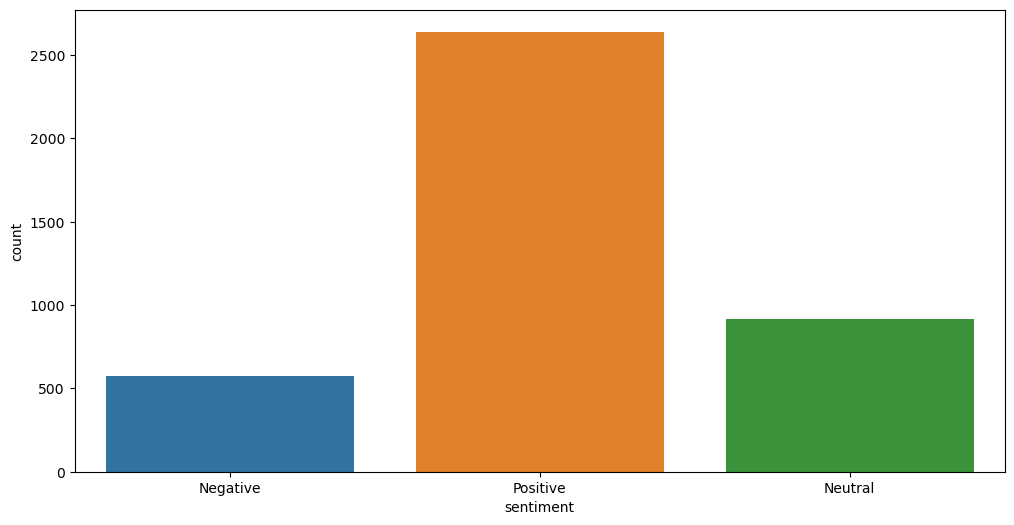

In [48]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)
plt.show()

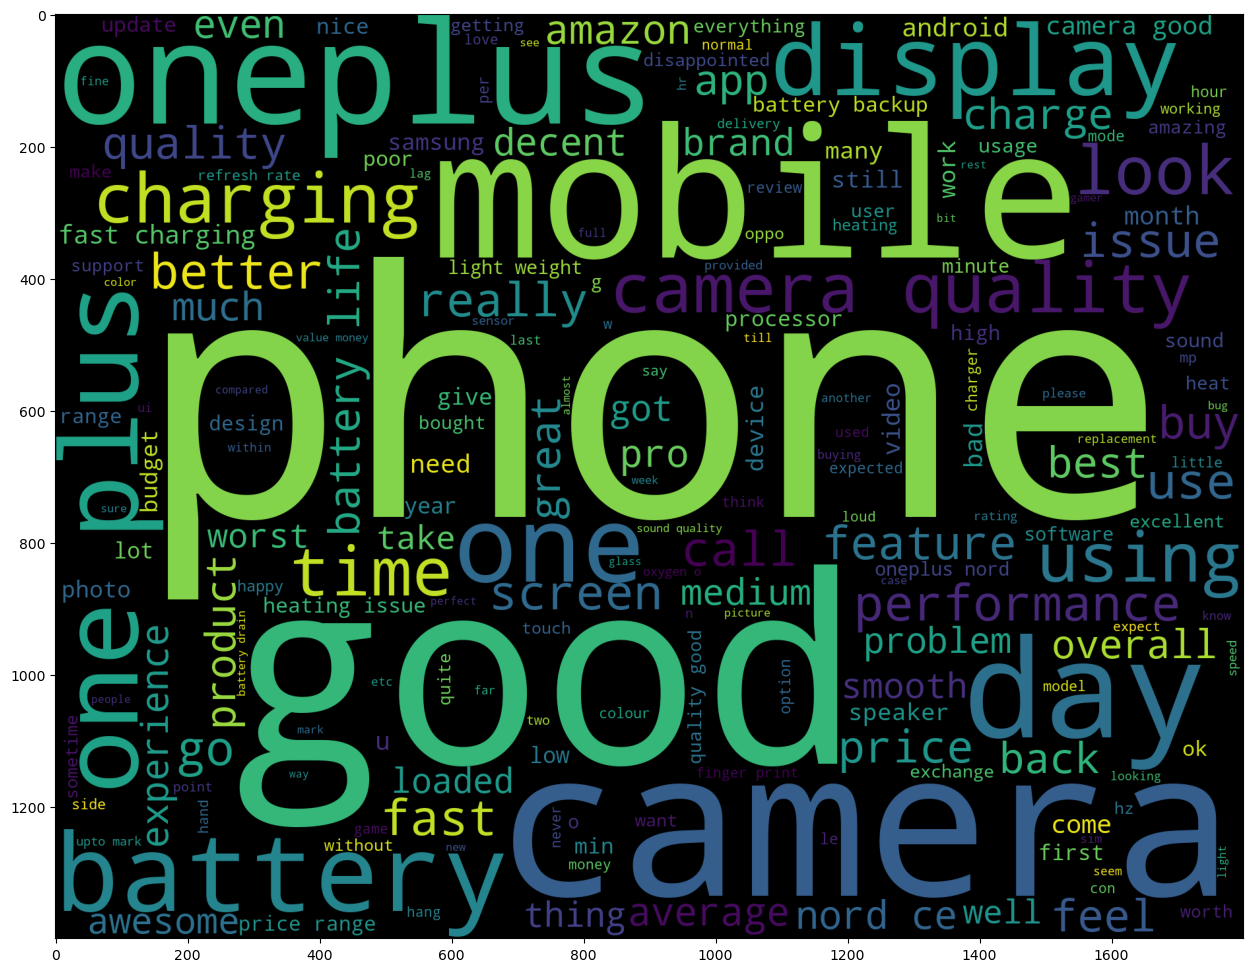

In [50]:
from wordcloud import WordCloud

allWords_ = ' '.join([review for review in dataframe[:500]['Clean_Reviews']])
f, axes = plt.subplots(figsize=(20,12))
wordcloud= WordCloud(
        background_color = 'black',
        width = 1800,
        height =1400).generate(allWords_)
plt.imshow(wordcloud)

### From the above analysis we can conclude that the phone OnePlus Nord CE2 has a positive response.